In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing


import warnings
warnings.filterwarnings('ignore')

In [4]:
# reading raw data file
har_df   =                     pd.read_csv('time_series_data_human_activities.csv')

# removing null values
har_df = har_df.dropna()
har_df.shape

(1073623, 6)

In [3]:
# drop the rows where timestamp is 0
df = har_df[har_df['timestamp'] != 0]

# now arrange data in ascending order of the user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

In [4]:
har_df

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.030000
1,1,Walking,4991972333000,6.85,7.44,-0.500000
2,1,Walking,4992022351000,0.93,5.63,-0.500000
3,1,Walking,4992072339000,-2.11,5.01,-0.690000
4,1,Walking,4992122358000,-4.59,4.29,-1.950000
...,...,...,...,...,...,...
1073618,36,Standing,15049012250000,-0.91,9.43,2.533385
1073619,36,Standing,15049062268000,-1.18,9.51,2.492524
1073620,36,Standing,15049112287000,-1.50,9.53,2.533385
1073621,36,Standing,15049162275000,-2.07,8.77,2.179256


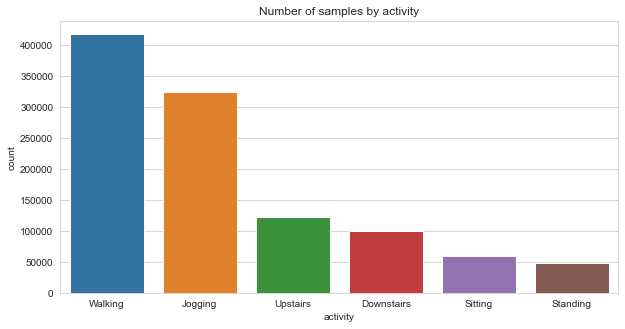

In [5]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.countplot(x = 'activity', data = df)
plt.title('Number of samples by activity')
plt.show()

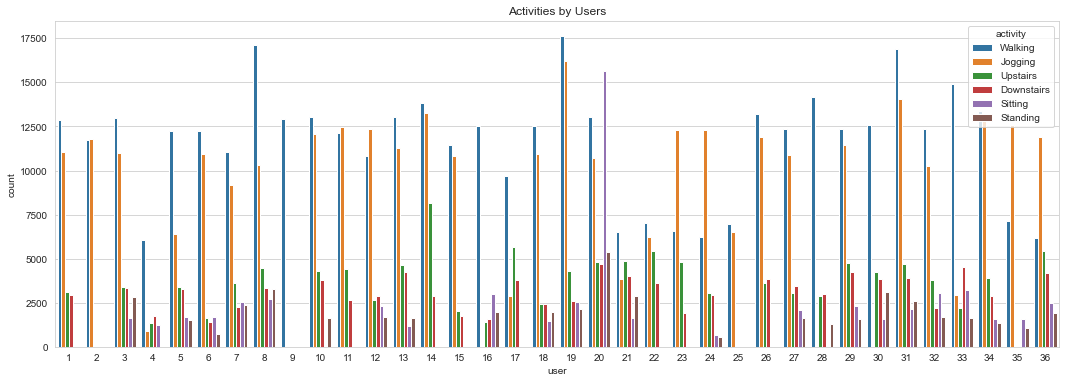

In [6]:
plt.figure(figsize = (18, 6))
sns.countplot(x = 'user', hue = 'activity', data = df)
plt.title('Activities by Users')
plt.show()

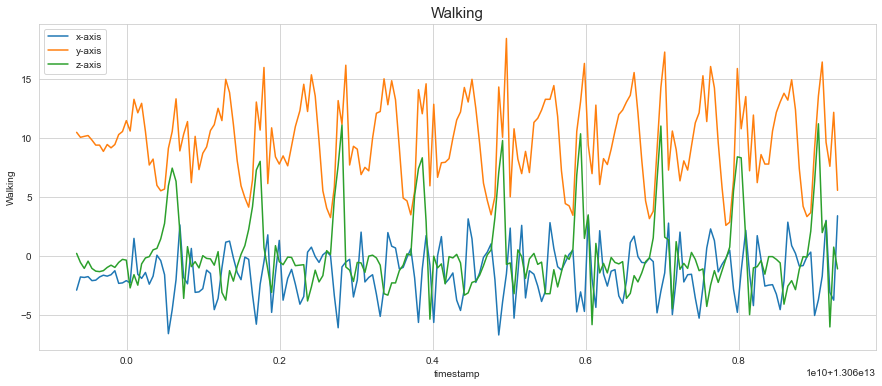

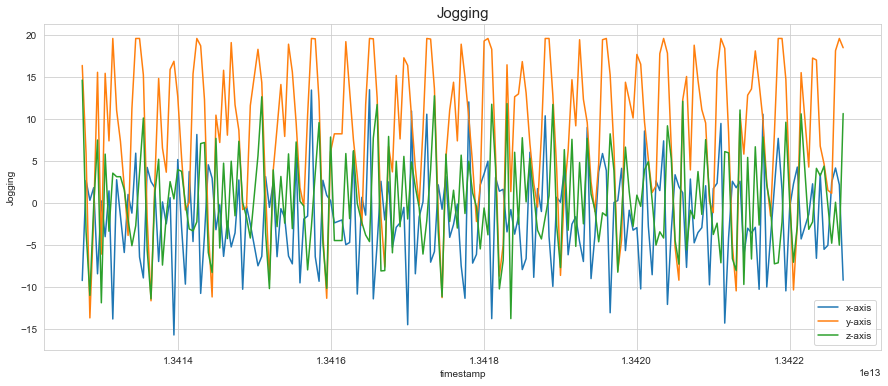

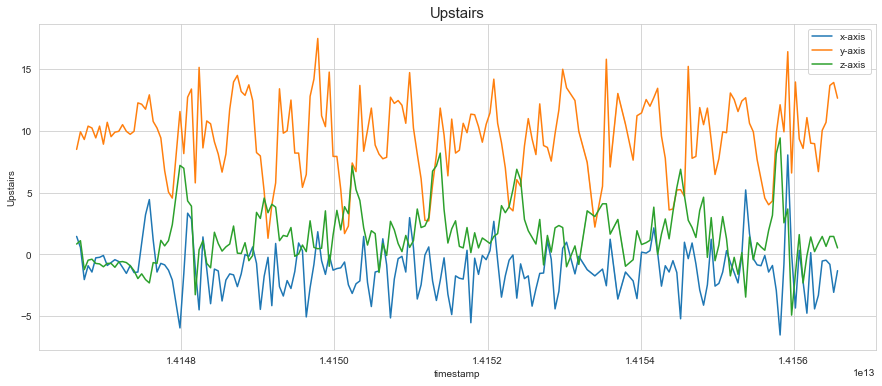

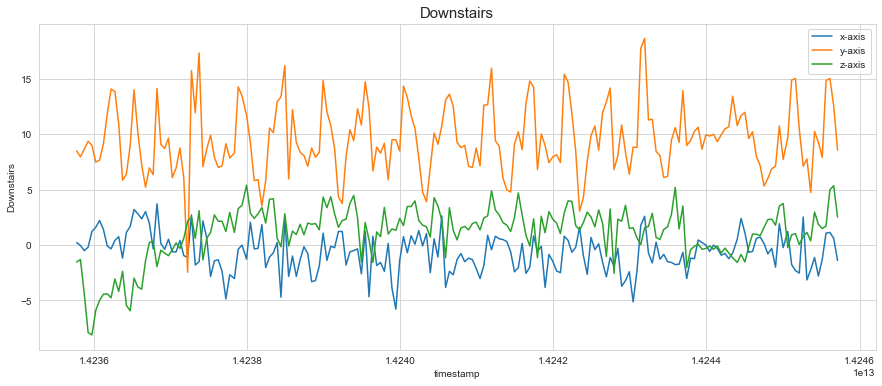

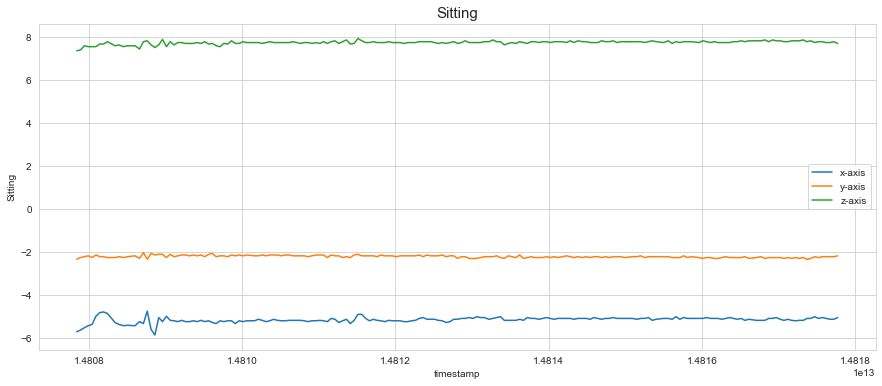

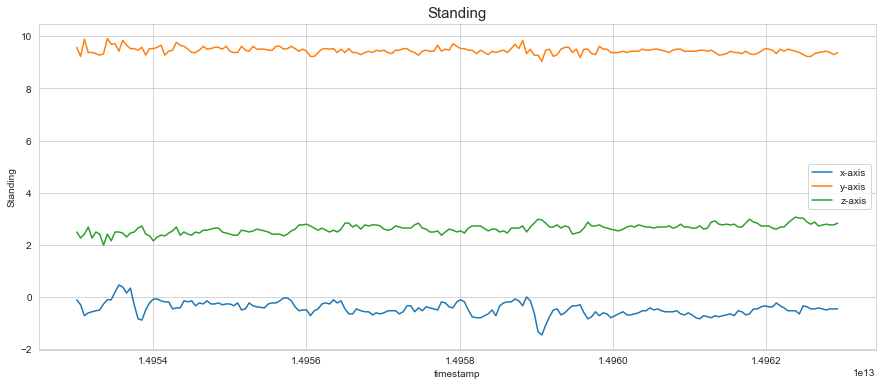

In [7]:
for i in ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']:
  data_36 = df[(df['user'] == 36) & (df['activity'] == i)][:200]
  plt.figure(figsize = (15, 6))
  sns.lineplot(y = 'x-axis', x = 'timestamp', data = data_36)
  sns.lineplot(y = 'y-axis', x = 'timestamp', data = data_36)
  sns.lineplot(y = 'z-axis', x = 'timestamp', data = data_36)
  plt.legend(['x-axis', 'y-axis', 'z-axis'])
  plt.ylabel(i)
  plt.title(i, fontsize = 15)
  plt.show()

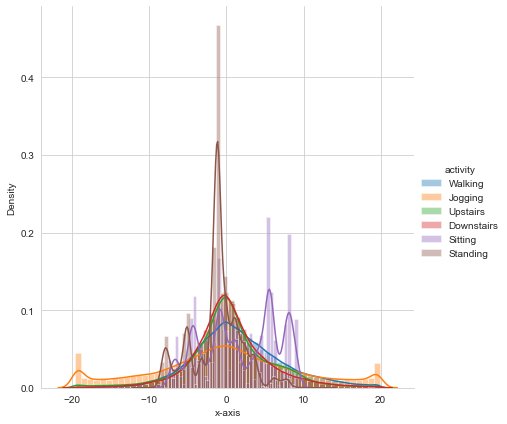

In [8]:
sns.FacetGrid(df, hue = 'activity', size = 6).map(sns.distplot, 'x-axis').add_legend()

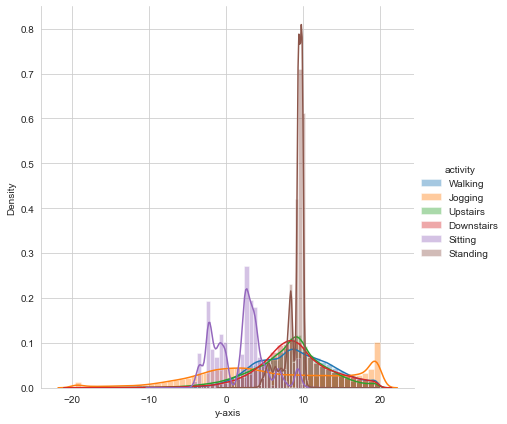

In [9]:
sns.FacetGrid(df, hue = 'activity', size = 6).map(sns.distplot, 'y-axis').add_legend()

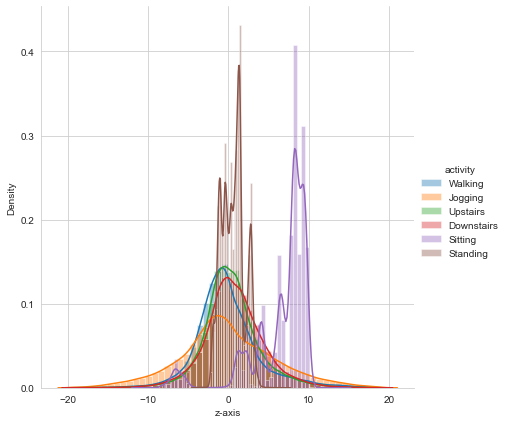

In [10]:
sns.FacetGrid(df, hue = 'activity', size = 6).map(sns.distplot, 'z-axis').add_legend()

In [11]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler = scaler.fit(df[['x-axis', 'y-axis', 'z-axis']])
# # 获取均值和标准差
# mean = scaler.mean_
# std = scaler.scale_
# 
# print("Mean:", mean)
# print("Standard Deviation:", std)
# 
# # 对训练和测试数据进行标准化
# df[['x-axis', 'y-axis', 'z-axis']] = scaler.transform(df[['x-axis', 'y-axis', 'z-axis']])

In [5]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [6]:
# The number of steps within one time segment
TIME_PERIODS = 100
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 50

In [7]:
from scipy.stats import moment

# x, y, z acceleration as features
N_FEATURES = 3

def create_segments_and_labels(df, time_steps, step, label_name):
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    users =[]
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
        user = stats.mode(df['user'][i: i + time_steps])[0][0]
        users.append(user-1)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    users = np.asarray(users)

    return reshaped_segments, labels, users

x, y, y_users = create_segments_and_labels(df,
                                          TIME_PERIODS,
                                          STEP_DISTANCE,
                                          LABEL)

In [8]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
print(LABELS)
print(le.transform(LABELS))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
[0 1 2 3 4 5]


In [9]:
from keras.utils.np_utils import to_categorical

Y_one_hot       = to_categorical(y)
Y_one_hot_users = to_categorical(y_users)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train_one_hot, y_test_one_hot = train_test_split(x, Y_one_hot, test_size=0.33, random_state=42)

In [11]:
import keras
from keras import models
from keras import layers

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Conv1D, MaxPooling2D
import keras
from keras.utils import np_utils
from tensorflow.keras import regularizers

In [12]:
model = models.Sequential()

# Reshape layer to add channel dimension
model.add(layers.Reshape((100, 3, 1), input_shape=(100, 3)))

# 2D Convolutional Layers with smaller kernel size and BatchNormalization
model.add(layers.Conv2D(filters=32, kernel_size=(3, 1), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 1), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 1)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 1)))

# Flatten and Dense Layers with increased units and L2 regularization
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))  # Adjusted Dropout rate
model.add(layers.Dense(6, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 100, 3, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 3, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 3, 32)        3104      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 3, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 3, 64)         6208      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 3, 64)         12352     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 3, 64)         0

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [21]:
#history = model.fit(x_train, y_train_one_hot, validation_data=(x_test, y_test_one_hot), epochs=30, batch_size=64)
history = model.fit(x_train, y_train_one_hot, epochs=50, batch_size=64, validation_data=(x_test, y_test_one_hot), callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
])

Epoch 1/50
225/225 [==============================] - 5s 12ms/step - loss: 1.1022 - accuracy: 0.7575 - val_loss: 0.5424 - val_accuracy: 0.8521
Epoch 2/50
225/225 [==============================] - 2s 9ms/step - loss: 0.5077 - accuracy: 0.8532 - val_loss: 0.4031 - val_accuracy: 0.8981
Epoch 3/50
225/225 [==============================] - 2s 9ms/step - loss: 0.4138 - accuracy: 0.8913 - val_loss: 0.3667 - val_accuracy: 0.9100
Epoch 4/50
225/225 [==============================] - 2s 9ms/step - loss: 0.3698 - accuracy: 0.9064 - val_loss: 0.2897 - val_accuracy: 0.9320
Epoch 5/50
225/225 [==============================] - 2s 9ms/step - loss: 0.3321 - accuracy: 0.9162 - val_loss: 0.3198 - val_accuracy: 0.9189
Epoch 6/50
225/225 [==============================] - 2s 9ms/step - loss: 0.3118 - accuracy: 0.9246 - val_loss: 0.2693 - val_accuracy: 0.9428
Epoch 7/50
225/225 [==============================] - 2s 9ms/step - loss: 0.2968 - accuracy: 0.9319 - val_loss: 0.2685 - val_accuracy: 0.9386
Epoch

222/222 [==============================] - 1s 4ms/step - loss: 0.1444 - accuracy: 0.9610
Test Loss: 0.14438383281230927
Test Accuracy: 0.9610499739646912


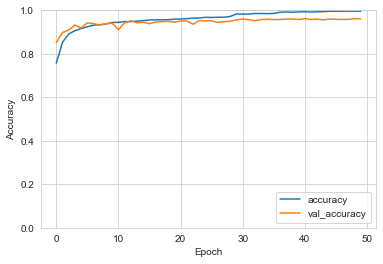

In [22]:
# 评估模型
loss, accuracy = model.evaluate(x_test, y_test_one_hot)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# 绘制训练过程中的损失和准确率曲线
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# 使用 predict 方法获取预测概率
y_pred_prob = model.predict(x_test)

# 使用 argmax 获取预测的类标签
y_pred = y_pred_prob.argmax(axis=-1)

# 检查 y_test 的格式
if len(y_test_one_hot.shape) > 1:  # 如果是 one-hot 编码
    y_test = y_test_one_hot.argmax(axis=-1)  # 转换为类标签
else:
    y_test = y_test_one_hot  # 如果已经是类标签，直接赋值

# 确保 y_pred 和 y_test 是一维数组
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# 创建混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 计算准确率、精确率、召回率和 F1 分数
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9610499576629975
Confusion Matrix:
 [[ 617    1    0    0   51   17]
 [  10 2117    2    0   16   11]
 [   0    0  373    3    0    1]
 [   0    0    4  319    0    0]
 [  77   32    0    0  682   20]
 [  19    5    0    0    7 2702]]
Precision: 0.9611016574276153
Recall: 0.9610499576629975
F1 Score: 0.9608898321398739


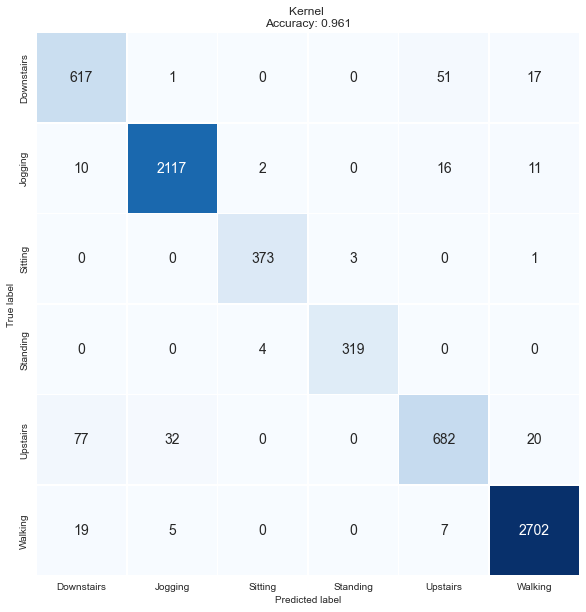

In [24]:
# 使用 predict 方法获取预测概率
y_pred_prob = model.predict(x_test)

# 使用 argmax 获取预测的类标签
y_pred = y_pred_prob.argmax(axis=-1)

# 将 y_test_one_hot 转换为类标签
y_test = y_test_one_hot.argmax(axis=-1)

# 创建混淆矩阵
cm = confusion_matrix(y_test, y_pred) 

# 将混淆矩阵转换为 DataFrame 以便于绘图
cm_df = pd.DataFrame(cm,
                     index=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'], 
                     columns=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)

# 绘制热图
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, fmt="d", linewidths=0.5, cmap='Blues', cbar=False, annot_kws={'size': 14}, square=True)
plt.title('Kernel \nAccuracy: {0:.3f}'.format(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']))

              precision    recall  f1-score   support

  Downstairs       0.85      0.90      0.88       686
     Jogging       0.98      0.98      0.98      2156
     Sitting       0.98      0.99      0.99       377
    Standing       0.99      0.99      0.99       323
    Upstairs       0.90      0.84      0.87       811
     Walking       0.98      0.99      0.99      2733

    accuracy                           0.96      7086
   macro avg       0.95      0.95      0.95      7086
weighted avg       0.96      0.96      0.96      7086



In [26]:
import os

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\34539\AppData\Local\Temp\tmpfn35mxfa\assets


In [28]:
# 保存量化后的模型
model_path = 'unquantized_model_CONV2.tflite'
with open(model_path, 'wb') as f:
    f.write(tflite_model)

# 查看量化后的模型大小
model_size = os.path.getsize(model_path)
print(f'TFLite 模型大小: {model_size / 1024:.2f} KB')

TFLite 模型大小: 2493.77 KB


In [29]:
# 定义代表性数据集生成器函数
def representative_dataset_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_test).batch(1).take(100):
        yield [input_value]
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\34539\AppData\Local\Temp\tmpif7bx234\assets


INFO:tensorflow:Assets written to: C:\Users\34539\AppData\Local\Temp\tmpif7bx234\assets


In [30]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']

output_type = interpreter.get_output_details()[0]['dtype']
input_type,output_type

(numpy.float32, numpy.float32)

In [31]:
# 保存量化后的模型
model_path = 'quantized_model_CONV2.tflite'
with open(model_path, 'wb') as f:
    f.write(tflite_model_quant)

# 查看量化后的模型大小
model_size = os.path.getsize(model_path)
print(f'TFLite 模型大小: {model_size / 1024:.2f} KB')

TFLite 模型大小: 633.73 KB


In [32]:
# 定义代表性数据集生成器函数
def representative_dataset_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_test).batch(1).take(100):
        yield [input_value]
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # 或者 tf.uint8
converter.inference_output_type = tf.int8  # 或者 tf.uint8
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\34539\AppData\Local\Temp\tmpiu4czv03\assets


INFO:tensorflow:Assets written to: C:\Users\34539\AppData\Local\Temp\tmpiu4czv03\assets


In [33]:
tflite_model_quant = converter.convert()
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']

output_type = interpreter.get_output_details()[0]['dtype']
input_type, output_type

INFO:tensorflow:Assets written to: C:\Users\34539\AppData\Local\Temp\tmp0oyztb8j\assets


INFO:tensorflow:Assets written to: C:\Users\34539\AppData\Local\Temp\tmp0oyztb8j\assets


(numpy.int8, numpy.int8)

In [34]:
# 保存量化后的模型
model_path = 'quantized_model_CONV2_INT.tflite'
with open(model_path, 'wb') as f:
    f.write(tflite_model_quant)

# 查看量化后的模型大小
model_size = os.path.getsize(model_path)
print(f'TFLite 模型大小: {model_size / 1024:.2f} KB')

TFLite 模型大小: 633.47 KB


In [35]:
# 加载量化后的 TFLite 模型
model_path = 'quantized_model_CONV2_INT.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# 获取输入和输出张量的信息
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 量化输入数据
def quantize_input(input_data, input_scale, input_zero_point):
    return (input_data / input_scale + input_zero_point).astype(np.int8)

# 获取量化参数
input_scale, input_zero_point = input_details[0]['quantization']

# 预测函数
def predict(interpreter, input_data):
    input_data_quant = quantize_input(input_data, input_scale, input_zero_point)
    interpreter.set_tensor(input_details[0]['index'], input_data_quant)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# 评估模型性能
correct_predictions = 0
total_predictions = len(x_test)

for i in range(total_predictions):
    input_data = np.expand_dims(x_test[i], axis=0)  # 扩展维度以匹配模型输入
    predictions = predict(interpreter, input_data)
    predicted_label = np.argmax(predictions)
    
    true_label = np.argmax(y_test_one_hot[i])  # 将独热编码转换为标签索引

    if predicted_label == true_label:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f'量化后的 TFLite 模型准确率: {accuracy:.4f}')

量化后的 TFLite 模型准确率: 0.9612
